The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==1.0.3


# Sentiment Analysis and the Dataset
:label:`sec_sentiment`


With the proliferation of online social media
and review platforms,
a plethora of
opinionated data
has been logged,
bearing great potential for
supporting decision making processes.
*Sentiment analysis*
studies people's sentiments
in their produced text,
such as product reviews,
blog comments,
and
forum discussions.
It enjoys wide applications
to fields as diverse as 
politics (e.g., analysis of public sentiments towards policies),
finance (e.g., analysis of sentiments of the market),
and 
marketing (e.g., product research and brand management).

Since sentiments
can be categorized
as discrete polarities or scales (e.g., positive and negative),
we can consider 
sentiment analysis 
as a text classification task,
which transforms a varying-length text sequence
into a fixed-length text category.
In this chapter,
we will use Stanford's [large movie review dataset](https://ai.stanford.edu/%7Eamaas/data/sentiment/)
for sentiment analysis. 
It consists of a training set and a testing set, 
either containing 25000 movie reviews downloaded from IMDb.
In both datasets, 
there are equal number of 
"positive" and "negative" labels,
indicating different sentiment polarities.


In [1]:
import os
import torch
from torch import nn
from d2l import torch as d2l

##  Reading the Dataset

First, download and extract this IMDb review dataset
in the path `../data/aclImdb`.


In [2]:
#@save
d2l.DATA_HUB['aclImdb'] = (d2l.DATA_URL + 'aclImdb_v1.tar.gz',
                          '01ada507287d82875905620988597833ad4e0903')

data_dir = d2l.download_extract('aclImdb', 'aclImdb')

Next, read the training and test datasets. Each example is a review and its label: 1 for "positive" and 0 for "negative".


In [3]:
#@save
def read_imdb(data_dir, is_train):
    """Read the IMDb review dataset text sequences and labels."""
    data, labels = [], []
    for label in ('pos', 'neg'):
        folder_name = os.path.join(data_dir, 'train' if is_train else 'test',
                                   label)
        for file in os.listdir(folder_name):
            with open(os.path.join(folder_name, file), 'rb') as f:
                review = f.read().decode('utf-8').replace('\n', '')
                data.append(review)
                labels.append(1 if label == 'pos' else 0)
    return data, labels

train_data = read_imdb(data_dir, is_train=True)
print('# trainings:', len(train_data[0]))
for x, y in zip(train_data[0][:3], train_data[1][:3]):
    print('label:', y, 'review:', x[:60])

# trainings: 25000
label: 1 review: Zentropa has much in common with The Third Man, another noir
label: 1 review: Zentropa is the most original movie I've seen in years. If y
label: 1 review: Lars Von Trier is never backward in trying out new technique


## Preprocessing the Dataset

Treating each word as a token
and filtering out words that appear less than 5 times,
we create a vocabulary out of the training dataset.


In [4]:
train_tokens = d2l.tokenize(train_data[0], token='word')
vocab = d2l.Vocab(train_tokens, min_freq=5, reserved_tokens=['<pad>'])

After tokenization,
let's plot the histogram of
review lengths in tokens.


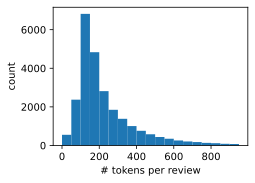

In [5]:
d2l.set_figsize()
d2l.plt.xlabel('# tokens per review')
d2l.plt.ylabel('count')
d2l.plt.hist([len(line) for line in train_tokens], bins=range(0, 1000, 50));

As we expected,
the reviews have varying lengths.
To process
a minibatch of such reviews at each time,
we set the length of each review to 500 with truncation and padding,
which is similar to 
the preprocessing step 
for the machine translation dataset
in :numref:`sec_machine_translation`.


In [6]:
num_steps = 500  # sequence length
train_features = torch.tensor([d2l.truncate_pad(
    vocab[line], num_steps, vocab['<pad>']) for line in train_tokens])
print(train_features.shape)

torch.Size([25000, 500])


## Creating Data Iterators

Now we can create data iterators.
At each iteration, a minibatch of examples are returned.


In [7]:
train_iter = d2l.load_array((train_features, torch.tensor(train_data[1])), 64)

for X, y in train_iter:
    print('X:', X.shape, ', y:', y.shape)
    break
print('# batches:', len(train_iter))

X: torch.Size([64, 500]) , y: torch.Size([64])
# batches: 391


## Putting It All Together

Last, we wrap up the above steps into the `load_data_imdb` function.
It returns training and test data iterators and the vocabulary of the IMDb review dataset.


In [8]:
#@save
def load_data_imdb(batch_size, num_steps=500):
    """Return data iterators and the vocabulary of the IMDb review dataset."""
    data_dir = d2l.download_extract('aclImdb', 'aclImdb')
    train_data = read_imdb(data_dir, True)
    test_data = read_imdb(data_dir, False)
    train_tokens = d2l.tokenize(train_data[0], token='word')
    test_tokens = d2l.tokenize(test_data[0], token='word')
    vocab = d2l.Vocab(train_tokens, min_freq=5)
    train_features = torch.tensor([d2l.truncate_pad(
        vocab[line], num_steps, vocab['<pad>']) for line in train_tokens])
    test_features = torch.tensor([d2l.truncate_pad(
        vocab[line], num_steps, vocab['<pad>']) for line in test_tokens])
    train_iter = d2l.load_array((train_features, torch.tensor(train_data[1])),
                                batch_size)
    test_iter = d2l.load_array((test_features, torch.tensor(test_data[1])),
                               batch_size,
                               is_train=False)
    return train_iter, test_iter, vocab

## Summary

* Sentiment analysis studies people's sentiments in their produced text, which is considered as a text classification problem that transforms a varying-length text sequence
into a fixed-length text category.
* After preprocessing, we can load Stanford's large movie review dataset (IMDb review dataset) into data iterators with a vocabulary.


## Exercises


1. What hyperparameters in this section can we modify to accelerate training sentiment analysis models?
1. Can you implement a function to load the dataset of [Amazon reviews](https://snap.stanford.edu/data/web-Amazon.html) into data iterators and labels for sentiment analysis?


[Discussions](https://discuss.d2l.ai/t/1387)
